<a href="https://colab.research.google.com/github/Expan75/team20-adverserial-artists/blob/dev-mnist/GAN_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q git+https://github.com/DeepTrackAI/deeplay.git
# %pip install deeplay
%pip install -q deeptrack --pre
%pip install -q multiprocess

import torch
from rich import print

# Define GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))

print(f"Torch version: {torch.__version__}\nCUDA version: {torch.version.cuda}\nDevice: {device}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 

Torch version: 2.2.1+cu121
CUDA version: 12.1
Device: cpu

In [2]:
import deeplay as dl
import deeptrack as dt
import torch.nn as nn
import torchvision
import multiprocess as mp
from pathlib import Path
import os

In [3]:
DATA_PATH: Path = Path.cwd() / "data"
DATA_PATH.mkdir(exist_ok=True)
os.environ["DATA_PATH"] = str(DATA_PATH)

mnist_dataset_path: Path = DATA_PATH / "MNIST_dataset" / "mnist"

if not mnist_dataset_path.exists():
    !cd $DATA_PATH && git clone https://github.com/DeepTrackAI/MNIST_dataset

train_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "train"),
)
test_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "test"),
)
files = dt.sources.Join(train_files, test_files)

Cloning into 'MNIST_dataset'...
remote: Enumerating objects: 70019, done.
remote: Counting objects: 100% (70019/70019), done.
remote: Compressing objects: 100% (70014/70014), done.
remote: Total 70019 (delta 4), reused 70008 (delta 2), pack-reused 0
Receiving objects: 100% (70019/70019), 37.33 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (70003/70003), done.


In [4]:
image_pipeline = (
    dt.LoadImage(files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

label_pipeline = dt.Value(files.label_name[0]) >> int

In [5]:
train_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=train_files)
test_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=test_files)

train_loader = dl.DataLoader(test_dataset, batch_size=64, shuffle=True)
test_loader = dl.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
from kornia.contrib import extract_tensor_patches, combine_tensor_patches
import numpy as np


class Generator(dl.UNet2d):
    def __init__(self, *args, **kwargs):
        self.patch_size = kwargs["channels"][0]
        super().__init__(*args, **kwargs)

    def forward(self, input):
        _, _, height, width = input.shape

        if any(l < self.patch_size for l in (height, width)):
            raise ValueError(
                f"Image ({height}x{width}) is smaller than kernel size ({self.patch_size}x{self.patch_size})"
            )

        stride = [np.gcd(height, self.patch_size), np.gcd(width, self.patch_size)]
        input_patches = extract_tensor_patches(input=input, window_size=self.patch_size, stride=stride).movedim(1, 0)

        output_patches = torch.vmap(super().forward)(input_patches).movedim(0, 1)

        output = combine_tensor_patches(
            patches=output_patches, original_size=(height, width), window_size=self.patch_size, stride=stride
        )

        return output


generator_model = Generator(
    in_channels=1,
    channels=[16, 32],
    out_channels=1,
    skip=dl.Cat()
).create()
print(generator_model)

Generator(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
    )
    (postprocess): Identity()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (upsample): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
      )
    )
  )
  (decoder): ConvolutionalDecoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (upsample): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (preprocess): Identity()
  )
  (skip): Cat()
)

In [19]:
class Discriminator1(dl.DeeplayModule):
    def __init__(
            self,
            in_channels,
            hidden_channels_cnn,
            hidden_channels_mlp,
            out_channels_cnn,
            out_features
        ):
        super().__init__()

        self.cnn = dl.ConvolutionalNeuralNetwork(
            in_channels=in_channels,
            hidden_channels=hidden_channels_cnn,
            out_channels=out_channels_cnn,
            pool=nn.MaxPool2d(kernel_size=2),
            out_activation=nn.ReLU,
        )

        self.pool = dl.Layer(nn.MaxPool2d, kernel_size=2)
        self.flatten = dl.Layer(nn.Flatten)

        self.dense = dl.MultiLayerPerceptron(
            in_features=6 * 6 * out_channels_cnn,
            hidden_features=hidden_channels_mlp,
            out_features=out_features,
            out_activation=nn.Identity,
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(self.pool(x))
        x = self.dense(x)

        return torch.sigmoid(x)

discriminator_1 = Discriminator1(
    in_channels=1,
    hidden_channels_cnn=[16, 32],
    hidden_channels_mlp=[32, 32],
    out_channels_cnn=64,
    out_features=1
).create()
print(discriminator_1)

Discriminator1(
  (cnn): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=2304, out_features=32, bias=True)
        (activation): ReLU()
      )
      (1): LinearBlock(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
      )
      (2): LinearBlock(
        (layer): Linear(in_features=32, out_features=1, bias=True)
        (activation): Identity()
      )
    )
  )
)

In [20]:
import matplotlib.pyplot as plt

class GAN(dl.Application):
    def __init__(self, generator, discriminator_1, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator_1 = discriminator_1

        self.automatic_optimization = False


    def configure_optimizers(self):
        generator_optimizer = self.create_optimizer_with_params(
            dl.Adam(), self.generator.parameters()
        )
        discriminator_1_optimizer = self.create_optimizer_with_params(
            dl.Adam(), self.discriminator_1.parameters()
        )

        return [generator_optimizer, discriminator_1_optimizer], []

    def forward(self, batch):
        return self.generator(batch)

    def training_step(self, batch, batch_idx):
        self.train()
        input, target = batch

        print(input.shape)

        g_opt, d_1_opt = self.optimizers()

        adversarial_output = self(input)

        print(adversarial_output.shape)

        plt.imshow(input[0].squeeze(),cmap="gray")
        plt.show()
        plt.imshow(adversarial_output[0].squeeze().detach().numpy(),cmap="gray")
        plt.show()

        raise


gan = GAN(
    generator=generator_model,
    discriminator_1=discriminator_1
)
print(gan)

GAN(
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (generator): Generator(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
      (postprocess): Identity()
    )
    (bottleneck): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
        )
      )
    )
    (decoder): ConvolutionalDecoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
        )
        (1): Conv2dBlock(
          (layer): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): Identity()
        )
      )
      (preprocess): Identity()
    )
    (skip): Cat()
  )
  (discriminator_1): Discriminator1(
    (cnn): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Linear(in_features=2304, out_features=32, bias=True)
          (activation): ReLU()
        )
        (1): LinearBlock(
          (layer): Linear(in_features=32, out_features=32, bias=True)
          (activation): ReLU()
        )
        (2): LinearBlock(
          (layer): Linear(in_features=32, out_features=1, bias=True)
          (activation): Identity()
        )
      )
    )
  )
)

┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ train_metrics   │ MetricCollection │      0 │
│ 1 │ val_metrics     │ MetricCollection │      0 │
│ 2 │ test_metrics    │ MetricCollection │      0 │
│ 3 │ generator       │ Generator        │ 28.7 K │
│ 4 │ discriminator_1 │ Discriminator1   │ 98.1 K │
└───┴─────────────────┴──────────────────┴────────┘

Trainable params: 126 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 126 K                                                                                                
Total estimated model params size (MB): 0

Output()

torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])

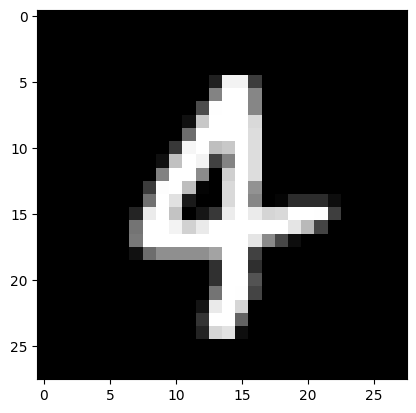

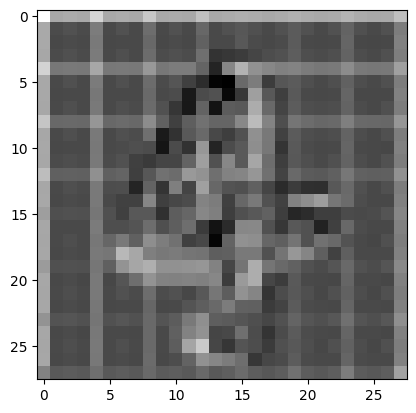

RuntimeError: No active exception to reraise

In [22]:
trainer = dl.Trainer(max_epochs=100)
trainer.fit(gan, train_loader)